# ML-model.ipynb

This file is responsible for taking all of the separate game csvs and putting them into one so we can have one trained model, then creating and implementing that model

After thinking on this some more it actually might make more sense to have a separate model for each game ... Still thinking this through though. Might depend on how computationally expensive it is to quickly train a model with one game's data and then make a prediction. One model could be better though if the game we are predicting has limited data and training one model off of only that data may not be sufficient.

In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



import warnings
warnings.filterwarnings("ignore")

folder = "data/CombinedPricePlayerCountHistory"
game_dfs = []

for filename in os.listdir(folder):
    if filename == "readme.md":
        continue

    # Construct filenames
    fullpath = os.path.join(folder, filename)
    appId, garbage_collector = os.path.splitext(filename)

    # Create data frame for each csv
    df = pd.read_csv(fullpath)
    df['appid'] = appId
    # Put appid first for visual pleasure
    cols = ['appid'] + [col for col in df if col != 'appid']
    df = df[cols]
    game_dfs.append(df)

# Combine them into one csv we can use to train
combined_df = pd.concat(game_dfs, ignore_index=True)

print(combined_df)

         appid        Date  Playercount  Initialprice  Finalprice  Discount
0       614570  2019-04-07          103         29.99       29.99         0
1       614570  2019-04-08           71         29.99       29.99         0
2       614570  2019-04-09           67         29.99       29.99         0
3       614570  2019-04-10           58         29.99       29.99         0
4       614570  2019-04-11           55         29.99       29.99         0
...        ...         ...          ...           ...         ...       ...
597477  228280  2020-08-08          622         19.99       19.99         0
597478  228280  2020-08-09          688         19.99       19.99         0
597479  228280  2020-08-10          558         19.99       19.99         0
597480  228280  2020-08-11          529         19.99       19.99         0
597481  228280  2020-08-12          520         19.99       19.99         0

[597482 rows x 6 columns]


Creating correlation matrix of features in our combined dataset.

         appid       Date  Playercount  Initialprice  Finalprice  Discount  \
0       614570 2019-04-07          103         29.99       29.99         0   
1       614570 2019-04-08           71         29.99       29.99         0   
2       614570 2019-04-09           67         29.99       29.99         0   
3       614570 2019-04-10           58         29.99       29.99         0   
4       614570 2019-04-11           55         29.99       29.99         0   
...        ...        ...          ...           ...         ...       ...   
597477  228280 2020-08-08          622         19.99       19.99         0   
597478  228280 2020-08-09          688         19.99       19.99         0   
597479  228280 2020-08-10          558         19.99       19.99         0   
597480  228280 2020-08-11          529         19.99       19.99         0   
597481  228280 2020-08-12          520         19.99       19.99         0   

        name releasedate  developer  publisher  
0        273  

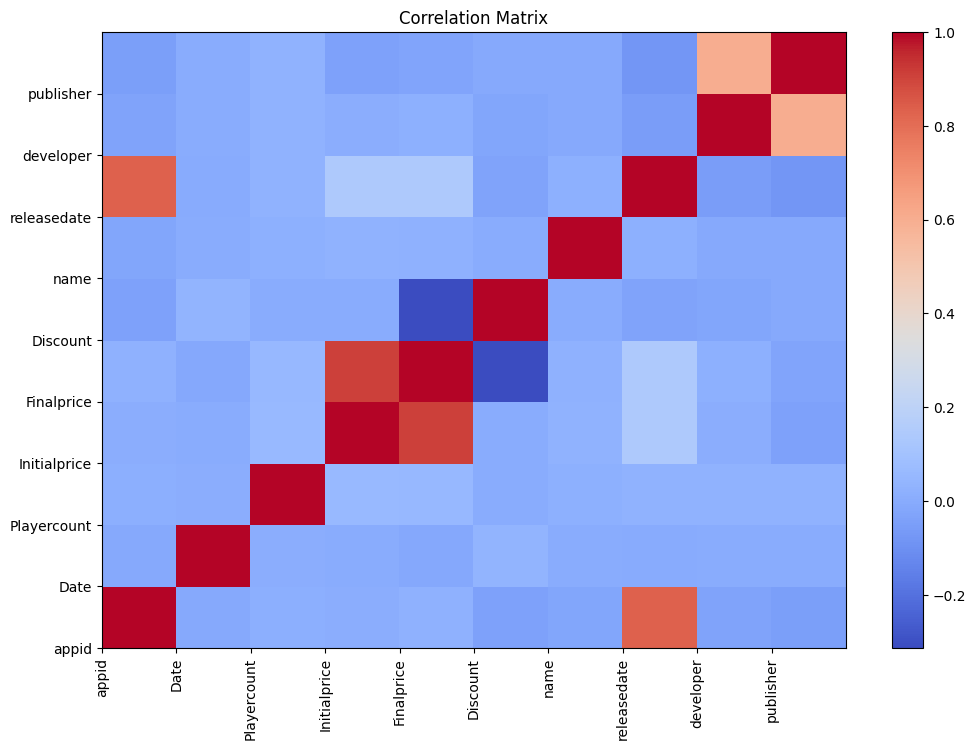

In [2]:
#pull in the rest of our merged info
merged_info_df = pd.read_csv("merged_info.csv")

#format combined_df
combined_df['appid'] = combined_df['appid'].astype('int64')
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

#merge combined_df and merged_info_df
full_df = combined_df.merge(merged_info_df,on='appid')

#drop redundant columns
full_df = full_df.drop('type', axis=1)
full_df = full_df.drop('freetoplay', axis=1)

#format dates, drop ones that do not follow format
full_df['releasedate'] = pd.to_datetime(full_df['releasedate'], format='%d-%b-%y',errors='coerce')
full_df = full_df.dropna(subset=['releasedate'])

#numerically encode string columns (name, dev, pub)
label_encoder = LabelEncoder()
full_df['name'] = label_encoder.fit_transform(full_df['name'])
full_df['developer'] = label_encoder.fit_transform(full_df['developer'])
full_df['publisher'] = label_encoder.fit_transform(full_df['publisher'])

#to check
print(full_df)

#create/plot correlation matrix
correlation_matrix = full_df.corr()
plt.figure(figsize=(12, 8))
heatmap = plt.pcolor(correlation_matrix, cmap='coolwarm')
plt.colorbar(heatmap)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

Now we will run this data frame through the decision tree classifier to make sure it is still able to make predictions off of it.
Here we are doing our train-test split based on a "split date" instead of just splitting it by # of entries.

In [3]:
#read in csv, convert date column to datetime object
full_df['Date'] = pd.to_datetime(full_df['Date'])
#make "discount" into a binary classifier (on sale or not on sale)
full_df['Discount'] = full_df['Discount'].apply(lambda x: 1 if x != 0 else 0)

#2/3 samples train/test split
samples = len(full_df)
split = math.floor(samples * (2/3))

#split at date 2/3 of the way through entry by using "split" to index into the df, get the date, and use that
split_date = full_df.iloc[split]['Date']
split_date = pd.to_datetime(split_date)
train_data = full_df[full_df['Date'] < split_date]
test_data = full_df[full_df['Date'] >= split_date]

#Considering 'Finalprice' spoils whether or not there is a discount/it's amount so we omit that feature
#Set up training data
#X_train = train_data[['Date', 'Playercount', 'Initialprice','Finalprice']]
X_train = train_data[['Date', 'Playercount', 'Initialprice']]
y_train = train_data['Discount']

#Set up testing data
#X_test = test_data[['Date', 'Playercount', 'Initialprice','Finalprice']]
X_test = test_data[['Date', 'Playercount', 'Initialprice']]
y_test = test_data['Discount']

#convert dates into something more compatible with our model (dates are not ML friendly)
X_train['DayOfWeek'] = X_train['Date'].dt.dayofweek
X_train['Month'] = X_train['Date'].dt.month
X_train['Year'] = X_train['Date'].dt.year
X_test['DayOfWeek'] = X_test['Date'].dt.dayofweek
X_test['Month'] = X_test['Date'].dt.month
X_test['Year'] = X_test['Date'].dt.year

#drop the old date
X_train = X_train.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

#fit classifier to training data
def plot_decision_tree(depth):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X_train, y_train)
    #plt.figure(figsize=(12, 8))
    #plot_tree(model, filled=True, feature_names=X_train.columns, class_names=True, rounded=True)
    #plt.show()
    #make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    #evaluate/print the accuracy
    print(f'{depth} Testing Accuracy:',accuracy_score(y_test, test_predictions))
    print(f'{depth} Training Accuracy:',accuracy_score(y_train, train_predictions))  

plot_decision_tree(2)
plot_decision_tree(4)
plot_decision_tree(8)


2 Testing Accuracy: 0.8226573125244065
2 Training Accuracy: 0.8718267108167771
4 Testing Accuracy: 0.8227084820166166
4 Training Accuracy: 0.871915723136082
8 Testing Accuracy: 0.822102527503602
8 Training Accuracy: 0.8725788649149042


Normal train-test split method

         appid  Playercount  Initialprice  Finalprice  name  developer  \
592744  562810           29         14.99       14.99   650        761   
156659  620130            0          3.99        3.99   154        578   
518309   42710          333         39.99       39.99   127        747   
448458  394510          103         19.99       19.99   455         51   
10992    58610           37          9.99        9.99  1182        254   
...        ...          ...           ...         ...   ...        ...   
212678  222750           37         19.99        9.99  1181        254   
182358  518790         2024         19.99       11.99  1239        258   
480199  359550        61354         19.99        7.99  1095        758   
86286   418240         1357         39.99        5.99   903        465   
207794  252470           15         19.99        7.99   952        466   

        publisher  DayOfWeek  Month  Year  ReleaseDayOfWeek  ReleaseMonth  \
592744        553          3     1

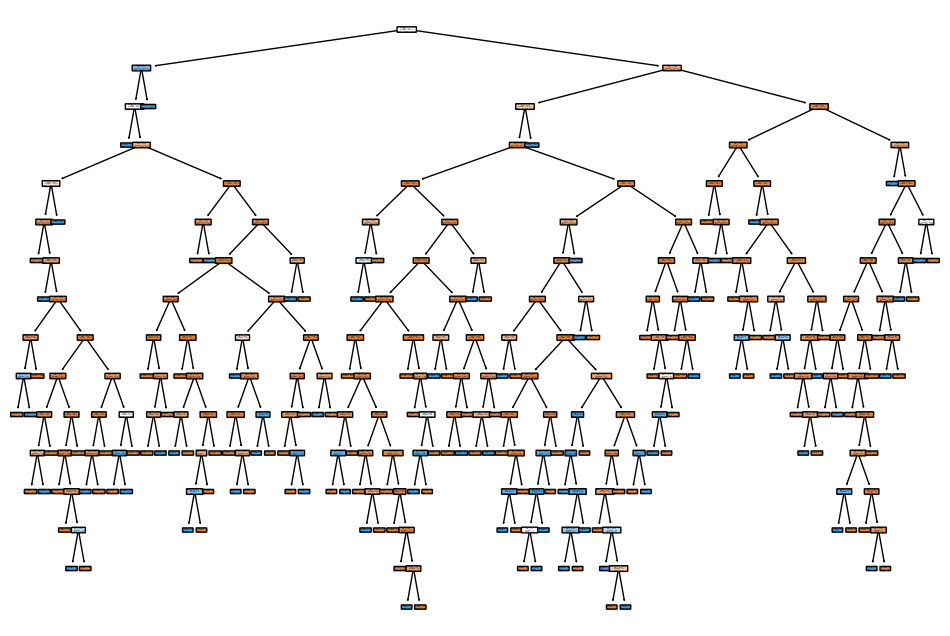

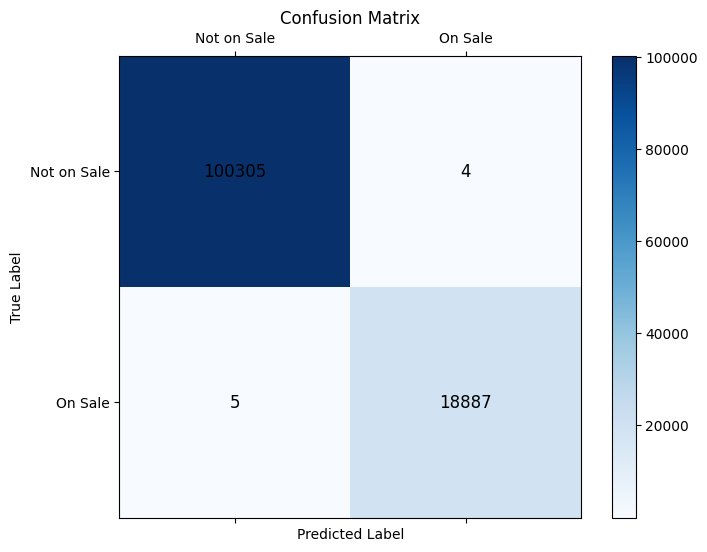

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100309
           1       1.00      1.00      1.00     18892

    accuracy                           1.00    119201
   macro avg       1.00      1.00      1.00    119201
weighted avg       1.00      1.00      1.00    119201

Testing Accuracy: 0.9999244972777074
Training Accuracy: 1.0


In [5]:
#read in csv, convert date column to datetime object
full_df['Date'] = pd.to_datetime(full_df['Date'])
#make "discount" into a binary classifier (on sale or not on sale)
full_df['Discount'] = full_df['Discount'].apply(lambda x: 1 if x != 0 else 0)
full_df.to_csv('all_data.csv',index=False)
y = full_df['Discount']
X = full_df.drop('Discount',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)

majority_class = train_data[train_data['Discount'] == 0]
minority_class = train_data[train_data['Discount'] == 1]

minority_class_oversampled = resample(minority_class,replace=True,n_samples=len(majority_class),random_state=42)

oversampled_data = pd.concat([majority_class, minority_class_oversampled])

X_train_resampled = oversampled_data.drop('Discount', axis=1)
y_train_resampled = oversampled_data['Discount']

X_train_resampled['DayOfWeek'] = X_train_resampled['Date'].dt.dayofweek
X_train_resampled['Month'] = X_train_resampled['Date'].dt.month
X_train_resampled['Year'] = X_train_resampled['Date'].dt.year
X_test['DayOfWeek'] = X_test['Date'].dt.dayofweek
X_test['Month'] = X_test['Date'].dt.month
X_test['Year'] = X_test['Date'].dt.year

X_train_resampled['ReleaseDayOfWeek'] = X_train_resampled['releasedate'].dt.dayofweek
X_train_resampled['ReleaseMonth'] = X_train_resampled['releasedate'].dt.month
X_train_resampled['ReleaseYear'] = X_train_resampled['releasedate'].dt.year
X_test['ReleaseDayOfWeek'] = X_test['releasedate'].dt.dayofweek
X_test['ReleaseMonth'] = X_test['releasedate'].dt.month
X_test['ReleaseYear'] = X_test['releasedate'].dt.year

#drop the old date
X_train_resampled = X_train_resampled.drop(['Date'], axis=1).drop(['releasedate'],axis=1)
X_test = X_test.drop(['Date'], axis=1).drop(['releasedate'],axis=1)

print(X_train_resampled)
print(X_test)
print(y_train_resampled)
print(y_test)

model = DecisionTreeClassifier()

# Train the model on the resampled training data
model.fit(X_train_resampled, y_train_resampled)

plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, feature_names=X_train_resampled.columns.to_list(), rounded=True)
plt.show()

# Make predictions on the testing set
test_prediction = model.predict(X_test)
train_prediction = model.predict(X_train_resampled)

cm = confusion_matrix(y_test, test_prediction)

# Display the confusion matrix as a heatmap using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar(cax)

# Set labels for the confusion matrix
classes = ['Not on Sale', 'On Sale']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Display the values in each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=12)

# Set labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

report = classification_report(y_test, test_prediction)
print(report)

# Evaluate the accuracy
test_accuracy = accuracy_score(y_test, test_prediction)
train_accuracy = accuracy_score(y_train_resampled, train_prediction)
print(f'Testing Accuracy: {test_accuracy}')
print(f'Training Accuracy: {train_accuracy}')